# Test Threshold

## Imports

In [1]:
from keras.layers.advanced_activations import PReLU
from keras.optimizers import Adam
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from models.u_net_heng import UNet_Heng
from utilities import utils_masks as utils
import random

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


## Preparing

In [2]:
input_size = 1024
train_path = "inputs/train/{}.jpg" 
train_mask_path = "inputs/train_masks/{}_mask.gif"
df_train = pd.read_csv('inputs/train_masks.csv')
ids_train = df_train['img'].map(lambda s: s.split('.')[0])
ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=42)

print('Training on {} samples'.format(len(ids_train_split)))
print('Validating on {} samples'.format(len(ids_valid_split)))

#bbox_file_path = 'inputs/train_bbox.csv'
#bboxes = utils.get_bboxes(pred_bbox_file_path)

def valid_generator(batch_size):
    return utils.valid_generator(train_path, train_mask_path, ids_valid_split, input_size, batch_size, bboxes=None)

Training on 4070 samples
Validating on 1018 samples


## Create Model

In [3]:
#U-Net-Heng:
model = UNet_Heng((input_size, input_size, 3))
model.compile(Adam(), loss='binary_crossentropy')
model.load_weights('weights/unet-heng-2017-09-16-0946.hdf5')

## Validation

In [8]:
def np_dice_value(y_true, y_pred):
    smooth = 1.
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def mean_dice_threshold(val_masks, val_pred_masks, thresholds):
    mean_dices = []
    max_mean_dice = 0
    max_threshold = 0
    for th in thresholds:
        np_dice_values = np.array([np_dice_value(mask, pred_mask > th) for (mask, pred_mask) in zip(val_masks, val_pred_masks)])
        mean_dice = np.mean(np_dice_values)
        if mean_dice > max_mean_dice:
            max_threshold = th
            max_mean_dice = mean_dice
        mean_dices.append(mean_dice)
        print('mean dice: {0}   threshold: {1}'.format(mean_dice, th))
    print('------------------------------------------------------')
    print('maximum mean dice: {0}   threshold: {1}'.format(max_mean_dice, max_threshold))
    return mean_dices

### Prediction

In [5]:
val_imgs, val_masks = next(valid_generator(len(ids_valid_split)))
val_pred_masks = model.predict(val_imgs, batch_size=1)

mean dice: 0.351216935651258   threshold: 0.0
mean dice: 0.9966012256042571   threshold: 0.01
mean dice: 0.9966047655287679   threshold: 0.02
mean dice: 0.9966063019402932   threshold: 0.03
mean dice: 0.9966076183745186   threshold: 0.04
mean dice: 0.9966083476822204   threshold: 0.05
mean dice: 0.9966092929883434   threshold: 0.06
mean dice: 0.9966096765670872   threshold: 0.07
mean dice: 0.9966099084666796   threshold: 0.08
mean dice: 0.9966101766850887   threshold: 0.09
mean dice: 0.9966106618584493   threshold: 0.1
mean dice: 0.9966108818396167   threshold: 0.11
mean dice: 0.9966110028309642   threshold: 0.12
mean dice: 0.9966110335876867   threshold: 0.13
mean dice: 0.9966111555363156   threshold: 0.14
mean dice: 0.9966111449598936   threshold: 0.15
mean dice: 0.9966112932981417   threshold: 0.16
mean dice: 0.9966115071252081   threshold: 0.17
mean dice: 0.9966116936856555   threshold: 0.18
mean dice: 0.9966117471084184   threshold: 0.19
mean dice: 0.9966117412462874   threshold: 

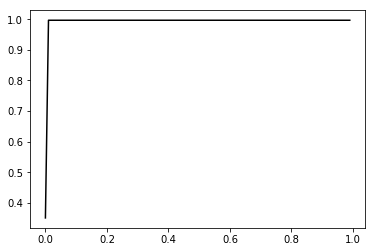

In [9]:
thresholds = np.arange(0, 1, 0.01)

mean_dices = mean_dice_threshold(val_masks, val_pred_masks, thresholds)
plt.figure()
plt.plot(thresholds, mean_dices, 'k')